In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from zlib import crc32

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


In [3]:
def fetch_housing_data (housing_url = HOUSING_URL,housing_path =HOUSING_PATH):
    os.makedirs(housing_path,exist_ok=True)
    tgz_path = os.path.join(housing_path,"housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,"housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:>

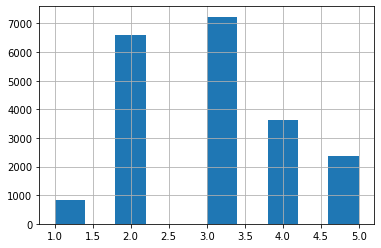

In [6]:
housing['income_cat'] = pd.cut(housing['median_income'],
    bins=[0,1.5,3,4.5,6,np.inf],
    labels=[1,2,3,4,5])
housing['income_cat'].hist()

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1,test_size=.2,random_state=42)

for train_index, test_index in split.split(housing,housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)
housing = strat_train_set.copy()

In [8]:
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND


In [9]:
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value",axis=1)

In [10]:
#Using SimpleImputer

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# imputer.fit(housing_num)

# X = imputer.transform(housing_num)
# housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing_num.index)

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder (BaseEstimator,TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler())
])

housing_num = housing.drop("ocean_proximity",axis=1)
housing_cat = housing[['ocean_proximity']]

# housing_num_tr = num_pipeline.fit_transform(housing_num)

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ("num",num_pipeline, num_attribs),
    ("cat",OneHotEncoder(),cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)


In [17]:
from sklearn.linear_model import LinearRegression 

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

from sklearn.metrics import mean_squared_error 
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Std Dev",scores.std())
print("TREE-------------->")
display_scores(tree_rmse_scores)

lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print("LINEAR------------------>")
display_scores(lin_rmse_scores)

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)

forest_scores = cross_val_score(forest_reg,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("FOREST------------------------>")
display_scores(forest_rmse_scores)

TREE-------------->
Scores: [73555.38549468 70884.33120294 69024.24504068 71268.60494496
 68677.81477534 76725.73163011 70700.88959658 72737.32738306
 67817.20957217 71037.91731593]
Mean: 71242.94569564471
Std Dev 2476.788595738149
LINEAR------------------>
Scores: [71800.38078269 64114.99166359 67844.95431254 68635.19072082
 66801.98038821 72531.04505346 73992.85834976 68824.54092094
 66474.60750419 70143.79750458]
Mean: 69116.4347200802
Std Dev 2880.6588594759014
FOREST------------------------>
Scores: [51410.12681005 49139.40385302 46684.67938478 51576.79298612
 47429.36070877 51691.93269993 52273.18879286 49669.62288763
 48748.83147472 54371.4707312 ]
Mean: 50299.54103290696
Std Dev 2252.376521162768


In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10],'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg,param_grid,scoring='neg_mean_squared_error',return_train_score=True, cv=5)

grid_search.fit(housing_prepared,housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [20]:
feature_importance = grid_search.best_estimator_.feature_importances_
extra_attribs = ['rooms_per_hhold','pop_per_hhold','bedrooms_per_rooms']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance,attributes), reverse = True)

[(0.3927871394028625, 'median_income'),
 (0.14714430664900777, 'INLAND'),
 (0.11305596845033475, 'pop_per_hhold'),
 (0.06696234014273679, 'longitude'),
 (0.06551124219661622, 'bedrooms_per_rooms'),
 (0.05961557115871918, 'latitude'),
 (0.04318922836983136, 'rooms_per_hhold'),
 (0.042909994089413976, 'housing_median_age'),
 (0.016216544865322105, 'total_rooms'),
 (0.014847096337779676, 'total_bedrooms'),
 (0.014732090554860404, 'population'),
 (0.014046560809103794, 'households'),
 (0.0037110389347705633, '<1H OCEAN'),
 (0.0032813273523315486, 'NEAR OCEAN'),
 (0.0018712533298758593, 'NEAR BAY'),
 (0.00011829735643348235, 'ISLAND')]

In [21]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47967.192726679365

In [22]:
from sklearn.svm import SVR

svr_reg = SVR()

param_grid = [
    {'kernel':['linear','rbf'], 'C':[1,2,3]}
]

grid_search = GridSearchCV(svr_reg,param_grid,scoring='neg_mean_squared_error',return_train_score=True, cv=5)

grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [1, 2, 3], 'kernel': ['linear', 'rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [23]:
grid_search.best_params_

{'C': 3, 'kernel': 'linear'}

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

feature_importances = grid_search.best_estimator_.feature_importances_

np.sort(np.argpartition(np.array(feature_importance), -5)[-5:])


array([ 0,  7,  9, 10, 12])

In [32]:
np.array(feature_importance)

array([6.83538513e-02, 5.90377267e-02, 4.36382182e-02, 1.67450032e-02,
       1.53227986e-02, 1.53546201e-02, 1.36463025e-02, 3.78303961e-01,
       5.00170107e-02, 1.14614304e-01, 6.01906858e-02, 6.76329745e-03,
       1.52657064e-01, 1.16122910e-04, 2.05419371e-03, 3.18484055e-03])

In [33]:
feature_importance

array([6.83538513e-02, 5.90377267e-02, 4.36382182e-02, 1.67450032e-02,
       1.53227986e-02, 1.53546201e-02, 1.36463025e-02, 3.78303961e-01,
       5.00170107e-02, 1.14614304e-01, 6.01906858e-02, 6.76329745e-03,
       1.52657064e-01, 1.16122910e-04, 2.05419371e-03, 3.18484055e-03])

In [47]:
x = np.array([3, 4, 2, 1,10,9,0,5])
print(x)
for i in range(-len(x),len(x)):
    print(i,np.partition(x,i))
np.argpartition(x, 3)

[ 3  4  2  1 10  9  0  5]
-8 [ 0  4  2  1 10  9  3  5]
-7 [ 0  1  2  4 10  9  3  5]
-6 [ 0  1  2  4 10  9  3  5]
-5 [ 0  1  2  3 10  9  4  5]
-4 [ 0  1  2  3  4  5  9 10]
-3 [ 0  1  2  3  4  5  9 10]
-2 [ 0  1  2  3  4  5  9 10]
-1 [ 0  1  2  3  4  5  9 10]
0 [ 0  4  2  1 10  9  3  5]
1 [ 0  1  2  4 10  9  3  5]
2 [ 0  1  2  4 10  9  3  5]
3 [ 0  1  2  3 10  9  4  5]
4 [ 0  1  2  3  4  5  9 10]
5 [ 0  1  2  3  4  5  9 10]
6 [ 0  1  2  3  4  5  9 10]
7 [ 0  1  2  3  4  5  9 10]


array([6, 3, 2, 0, 4, 5, 1, 7])

In [44]:
k=5
np.sort(np.argpartition(np.array(feature_importance), -k)[-k:])

array([ 0,  7,  9, 10, 12])

In [51]:
print(np.argpartition(np.array(feature_importance), -k))
print(np.argpartition(np.array(feature_importance), -k)[-k:])

[15 13 14 11  6  4  5  3  2  8  1 10  0 12  9  7]
[10  0 12  9  7]


In [52]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])
indices_of_top_k(feature_importance,5)

array([ 0,  7,  9, 10, 12])

In [72]:
class TopFeatureSelector(BaseEstimator,TransformerMixin):
    def __init__(self,feature_importances,k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self,X,y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances,self.k)
        return self
    def transform(self,X):
        return X[:,self.feature_indices_]

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [73]:
prepration_and_feature_selection_pipeline = Pipeline([
    ('preparation',full_pipeline),
    ('feature_selection',TopFeatureSelector(feature_importances,k))
])

In [74]:
housing_prep_and_top_k = prepration_and_feature_selection_pipeline.fit_transform(housing)